In [43]:
# import native python modules
import os
from pathlib import Path
import sys
sys.path.insert(0, '..')

# import installed python modules
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# import package modules
import energy_flexibility_kpis.kpi as kpi

In [45]:
# read test dataset
data_directory = Path('../data/test_dataset')
baseline_data = pd.read_csv(os.path.join(data_directory, 'baseline.csv'))
mpc_data = pd.read_csv(os.path.join(data_directory, 'mpc_results.csv'))
signal_data = pd.read_csv(os.path.join(data_directory, 'ToU.csv'))
print('Baseline:')
display(baseline_data.head(3))
print('MPC (flexible):')
display(mpc_data.head(3))
print('Signals:')
display(signal_data.head(3))

Baseline:


,Qh_hp,Qh_direct,Qh_other,I_solar,Ti,To,dt,Datetime,P_sig,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
0,4187.394125,3.417003,566.443167,-0.031968,21.64400,2.618578,60.0,2021-12-17 00:00:00,7.0,0.069790,0.030926,81.704760,False,False,False
1,4274.190399,3.374273,565.407264,-0.027049,21.71392,2.627933,60.0,2021-12-17 00:01:00,7.0,0.071237,0.031567,81.483446,False,False,False
2,4327.706775,3.256316,563.102595,-0.026358,21.76967,2.611456,60.0,2021-12-17 00:02:00,7.0,0.072128,0.031963,81.457686,False,False,False


MPC (flexible):


,Datetime,t_seconds,T_i,Qh_hp,T_o,T_set,T_comfort_u,T_comfort_l,I_sol,Q_in,P_sig,Cost,Qh_hp_kWh,Energy_hp_kWh,Non-HVAC Power (W),Pre-event,Peak,Post-event
0,2021-12-17 00:00:00,0.0,22.933165,-4.904006e-09,2.618578,22.222222,24.222222,21.722222,-0.031968,187.197800,7.0,-3.432804e-08,-8.173344e-14,-3.621898e-14,359.164843,False,False,False
1,2021-12-17 00:01:00,60.0,22.915338,3.539341e-06,2.627933,22.222222,24.222222,21.722222,-0.027049,187.473033,7.0,2.477539e-05,5.898902e-11,2.614012e-11,359.650083,False,False,False
2,2021-12-17 00:02:00,120.0,22.897539,3.588183e-06,2.611456,22.222222,24.222222,21.722222,-0.026358,187.415433,7.0,2.511728e-05,5.980306e-11,2.650085e-11,359.806033,False,False,False


Signals:


,Datetime,ToU,Post-event,Pre-event,Peak
0,2021-12-17 00:00:00,7,False,False,False
1,2021-12-17 00:01:00,7,False,False,False
2,2021-12-17 00:02:00,7,False,False,False


In [71]:
# map variables
data = pd.DataFrame({
    'timestamp': mpc_data['Datetime'],
    'baseline_electric_power_profile': baseline_data['Qh_hp'],
    'flexible_electric_power_profile': mpc_data['Qh_hp'],
    'baseline_electricity_consumption_profile': baseline_data['Qh_hp_kWh'],
    'flexible_electricity_consumption_profile': mpc_data['Qh_hp_kWh'],
    'peak_period': signal_data['Peak'],
})
data['timestamp'] = pd.to_datetime(data['timestamp'])

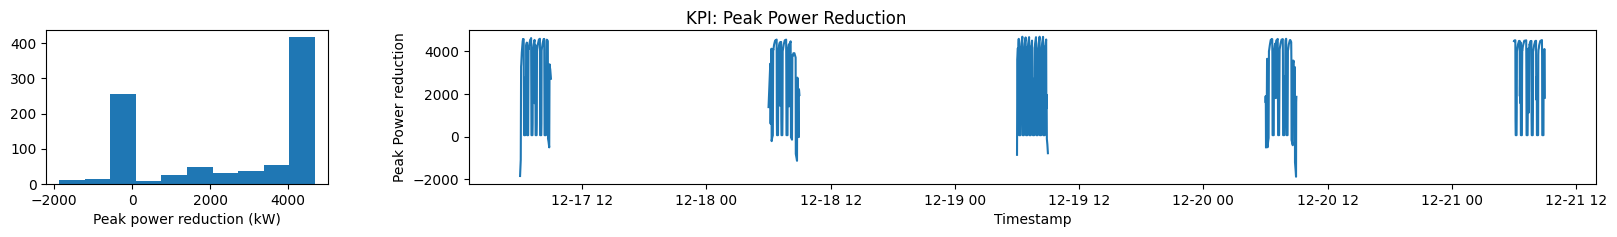

In [26]:
# peak power reduction
input_data = data[data['peak_period']==True].copy()
kpi_list = [kpi.peak_power_reduction(
    timestamps=[r['timestamp']],
    grid_peak_timestamp=r['timestamp'],
    baseline_electric_power_profile=[r['baseline_electric_power_profile']],
    flexible_electric_power_profile=[r['flexible_electric_power_profile']],
) for r in input_data.to_records(index=False)]

# plot results
fig, axs = plt.subplots(1, 2, figsize=(20, 2), gridspec_kw={'width_ratios': [0.2, 0.8]})
axs[0].hist(kpi_list)
axs[0].set_xlabel('Peak power reduction (kW)')
plot_data = pd.DataFrame({'timestamp':input_data['timestamp'], 'kpi': kpi_list})
plot_data = data.merge(plot_data, on='timestamp', how='left')
axs[1].plot(plot_data['timestamp'], plot_data['kpi'])
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Peak Power reduction')
fig.suptitle('KPI: Peak Power Reduction')
plt.show()

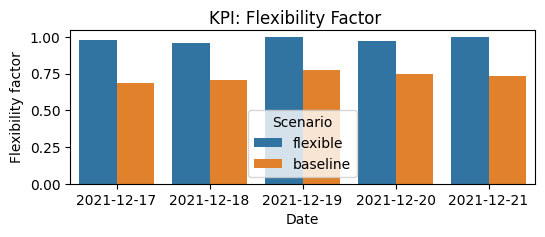

In [65]:
# flexibility factor
# -> daily evaluation periods
plot_data = {'date': [], 'flexible': [], 'baseline': []}

for d, d_data in data.groupby(data['timestamp'].dt.normalize()):
    plot_data['date'].append(d.strftime('%Y-%m-%d'))
    high_price_start_timestamp = d_data[d_data['peak_period']==True]['timestamp'].min()
    high_price_end_timestamp = d_data[d_data['peak_period']==True]['timestamp'].max()

    for k, c in zip(['flexible', 'baseline'], ['flexible_electricity_consumption_profile', 'baseline_electricity_consumption_profile']):
        result = kpi.flexibility_factor(
            timestamps=d_data['timestamp'],
            generic_electricity_consumption_profile=d_data[c],
            high_price_start_timestamp=high_price_start_timestamp,
            high_price_end_timestamp=high_price_end_timestamp
        )
        plot_data[k].append(result)

plot_data = pd.DataFrame(plot_data)
plot_data = plot_data.melt(id_vars=['date'], value_vars=['flexible', 'baseline'])

# plot results
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.barplot(x='date', y='value', hue='variable', data=plot_data)
ax.set_xlabel('Date')
ax.set_ylabel('Flexibility factor')
fig.suptitle('KPI: Flexibility Factor')
ax.legend(title='Scenario')
plt.show()

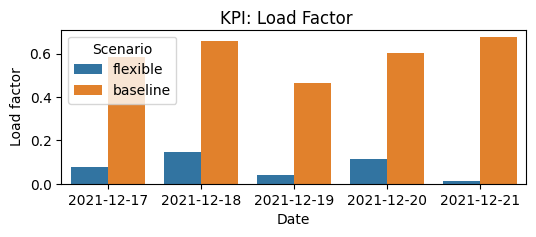

In [76]:
# load factor
# -> daily evaluation periods
plot_data = {'date': [], 'flexible': [], 'baseline': []}

for d, d_data in data.groupby(data['timestamp'].dt.normalize()):
    plot_data['date'].append(d.strftime('%Y-%m-%d'))
    peak_period = d_data[d_data['peak_period']==True].copy()

    for k, c in zip(['flexible', 'baseline'], ['flexible_electric_power_profile', 'baseline_electric_power_profile']):
        load_profile_peak_timestamp = peak_period['timestamp'].loc[peak_period[c].idxmax()]
        result = kpi.load_factor(
            timestamps=peak_period['timestamp'],
            generic_electric_power_profile=peak_period[c],
            load_profile_peak_timestamp=load_profile_peak_timestamp,
        )
        plot_data[k].append(result)

plot_data = pd.DataFrame(plot_data)
plot_data = plot_data.melt(id_vars=['date'], value_vars=['flexible', 'baseline'])

# plot results
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.barplot(x='date', y='value', hue='variable', data=plot_data)
ax.set_xlabel('Date')
ax.set_ylabel('Load factor')
fig.suptitle('KPI: Load Factor')
ax.legend(title='Scenario')
plt.show()